In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os, cv2, json
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB0, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation

# ignoring warnings
import warnings
warnings.simplefilter("ignore")


WORK_DIR = "../input/cassava-leaf-disease-classification/"
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [2]:
with open(WORK_DIR + "label_num_to_disease_map.json", 'r') as file:
    labels = json.load(file)
    labelnames = {int(k): v for k,v in labels.items()}
    
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [3]:
data = pd.read_csv(WORK_DIR + "train.csv")

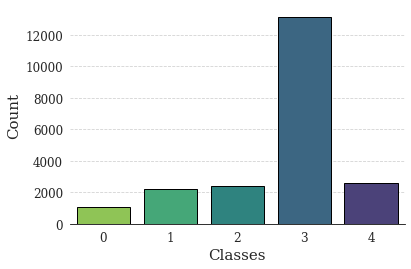

In [4]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (6, 4))

for i in ['top', 'right', 'left']:
    ax.spines[i].set_visible(False)
ax.spines['bottom'].set_color('black')

sns.countplot(data.label, edgecolor = 'black',
              palette = reversed(sns.color_palette("viridis", 5)))
plt.xlabel('Classes', fontfamily = 'serif', size = 15)
plt.ylabel('Count', fontfamily = 'serif', size = 15)
plt.xticks(fontfamily = 'serif', size = 12)
plt.yticks(fontfamily = 'serif', size = 12)
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show()

In [4]:
# Main parameters
#BATCH_SIZE = 8
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(data)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(data)*0.2 / BATCH_SIZE
EPOCHS = 25
#TARGET_SIZE = 512
TARGET_SIZE = 380

In [5]:
data.label = data.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(data,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(data,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


Found 1 validated image filenames belonging to 1 classes.


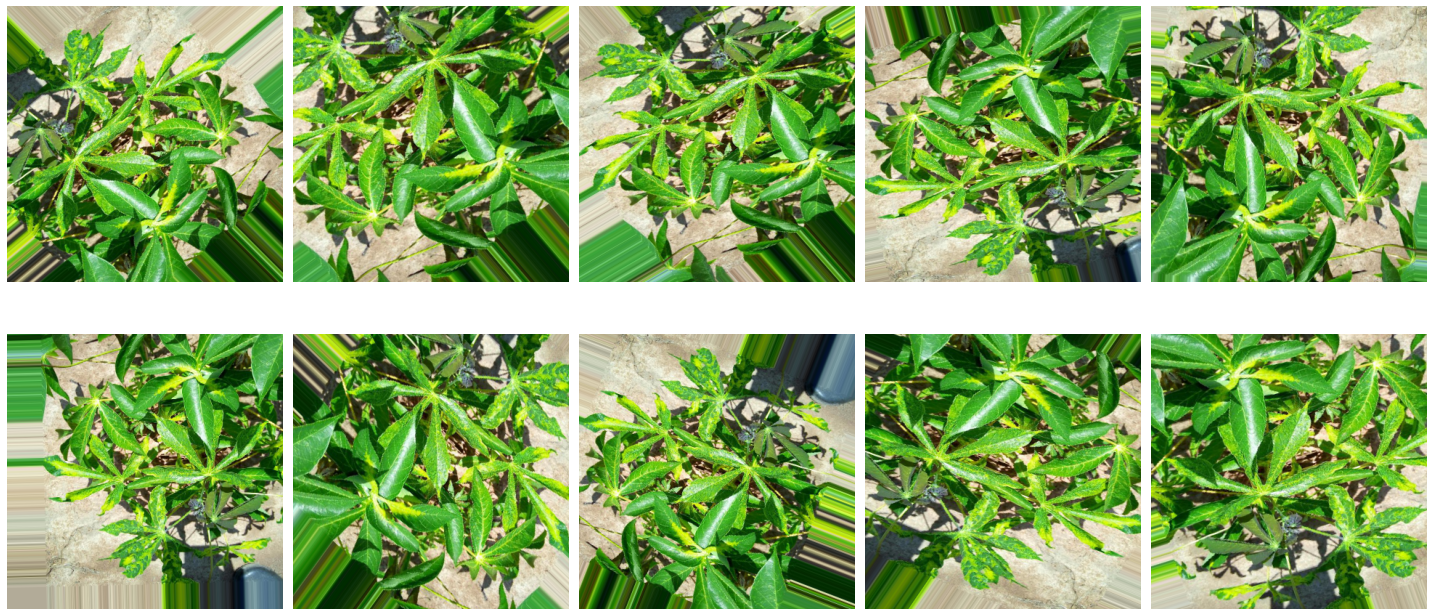

In [6]:
generator = train_datagen.flow_from_dataframe(data.iloc[35:36],
                         directory = os.path.join(WORK_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
classes_to_predict = sorted(data.label.unique())
dropout_rate = 0.3

def create_model():
    model = models.Sequential()
    model.add(EfficientNetB4(include_top = False, weights = None,
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes_to_predict), activation="softmax"))
    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  #metrics = ["acc"])
                  metrics = ["sparse_categorical_accuracy"])
    return model

In [9]:
model = create_model()
model.summary()

2021-12-18 22:07:35.319301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 22:07:35.421878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 22:07:35.422707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 22:07:35.424037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 12, 12, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 17,557,581
Non-trainable params: 125,207
_________________________________________________________________


In [10]:
model_save = ModelCheckpoint('./EffNetB4_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

2021-12-18 22:07:42.384056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2021-12-18 22:08:01.575723: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1069/1069 [==============================] - 1130s 1s/step - loss: 1.1732 - sparse_categorical_accuracy: 0.6105 - val_loss: 1.0621 - val_sparse_categorical_accuracy: 0.6368

Epoch 00001: val_loss improved from inf to 1.06207, saving model to ./EffNetB4_best_weights.h5
Epoch 2/25
1069/1069 [==============================] - 997s 931ms/step - loss: 1.0205 - sparse_categorical_accuracy: 0.6334 - val_loss: 0.9123 - val_sparse_categorical_accuracy: 0.6490

Epoch 00002: val_loss improved from 1.06207 to 0.91234, saving model to ./EffNetB4_best_weights.h5
Epoch 3/25
1069/1069 [==============================] - 993s 928ms/step - loss: 0.8973 - sparse_categorical_accuracy: 0.6604 - val_loss: 0.8501 - val_sparse_categorical_accuracy: 0.6789

Epoch 00003: val_loss improved from 0.91234 to 0.85010, saving model to ./EffNetB4_best_weights.h5
Epoch 4/25
1069/1069 [==============================] - 983s 919ms/step - loss: 0.8310 - sparse_categorical_accuracy: 0.6893 - val_loss: 0.7838 - val_sparse_ca

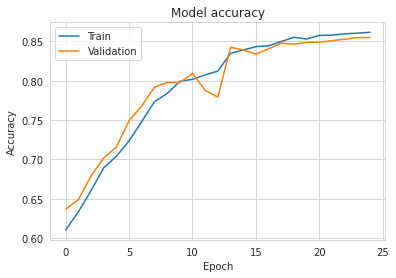

In [11]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

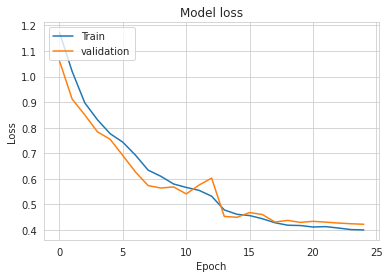

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [11]:
def create_model1():
    model1 = models.Sequential()
    model1.add(EfficientNetB0(include_top = False, weights = None,
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    model1.add(layers.GlobalAveragePooling2D())
    model1.add(Dropout(dropout_rate))
    model1.add(Dense(len(classes_to_predict), activation="softmax"))
    model1.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  #metrics = ["acc"])
                  metrics = ["sparse_categorical_accuracy"])
    return model1

In [12]:
model1 = create_model1()
model1.summary()

2021-12-19 05:23:31.542157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 05:23:31.643039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 05:23:31.643800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 05:23:31.645434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 12, 12, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [13]:
model_save1 = ModelCheckpoint('./EffNetB0_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop1 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history1 = model1.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save1, early_stop1, reduce_lr1]
)

2021-12-19 05:23:47.426057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2021-12-19 05:23:56.126664: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1069/1069 [==============================] - 880s 809ms/step - loss: 1.0681 - sparse_categorical_accuracy: 0.6209 - val_loss: 0.9462 - val_sparse_categorical_accuracy: 0.6516

Epoch 00001: val_loss improved from inf to 0.94617, saving model to ./EffNetB0_best_weights.h5
Epoch 2/25
1069/1069 [==============================] - 783s 732ms/step - loss: 0.8962 - sparse_categorical_accuracy: 0.6661 - val_loss: 1.1755 - val_sparse_categorical_accuracy: 0.5506

Epoch 00002: val_loss did not improve from 0.94617
Epoch 3/25
1069/1069 [==============================] - 782s 731ms/step - loss: 0.8217 - sparse_categorical_accuracy: 0.6915 - val_loss: 0.8564 - val_sparse_categorical_accuracy: 0.6941

Epoch 00003: val_loss improved from 0.94617 to 0.85640, saving model to ./EffNetB0_best_weights.h5
Epoch 4/25
1069/1069 [==============================] - 769s 719ms/step - loss: 0.7599 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.7929 - val_sparse_categorical_accuracy: 0.7177

Epoch 00004: val_l

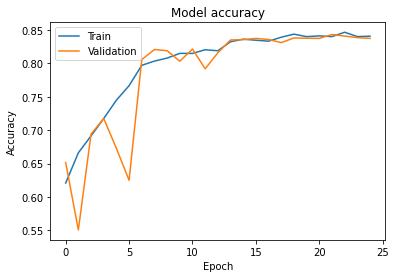

In [14]:
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history1.history['val_sparse_categorical_accuracy'])
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

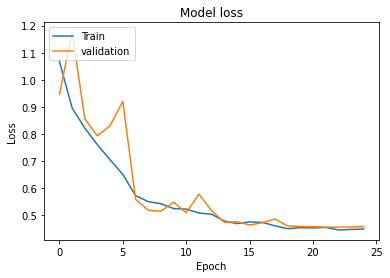

In [15]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [8]:
classes_to_predict = sorted(data.label.unique())
dropout_rate = 0.3

def create_model2():
    model2 = models.Sequential()
    model2.add(Xception(include_top = False, weights = None,
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    model2.add(layers.GlobalAveragePooling2D())
    model2.add(Dropout(dropout_rate))
    model2.add(Dense(len(classes_to_predict), activation="softmax"))
    model2.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  #metrics = ["acc"])
                  metrics = ["sparse_categorical_accuracy"])
    return model2

In [9]:
model2 = create_model2()
model2.summary()

2021-12-19 12:28:24.394659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 12:28:24.490415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 12:28:24.491105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 12:28:24.492238: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 12, 12, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [11]:
model_save2 = ModelCheckpoint('./Xception_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop2 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr2 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history2 = model2.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save2, early_stop2, reduce_lr2]
)

Epoch 1/25
1069/1069 [==============================] - 916s 855ms/step - loss: 0.8212 - sparse_categorical_accuracy: 0.6946 - val_loss: 0.9128 - val_sparse_categorical_accuracy: 0.6679

Epoch 00001: val_loss improved from inf to 0.91280, saving model to ./Xception_best_weights.h5
Epoch 2/25
1069/1069 [==============================] - 920s 859ms/step - loss: 0.7315 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.7306 - val_sparse_categorical_accuracy: 0.7488

Epoch 00002: val_loss improved from 0.91280 to 0.73063, saving model to ./Xception_best_weights.h5
Epoch 3/25
1069/1069 [==============================] - 929s 868ms/step - loss: 0.6622 - sparse_categorical_accuracy: 0.7612 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.5924

Epoch 00003: val_loss did not improve from 0.73063
Epoch 4/25
1069/1069 [==============================] - 914s 854ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7766 - val_loss: 0.7515 - val_sparse_categorical_accuracy: 0.7593

Epoch 0

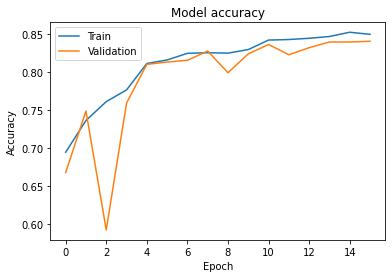

In [12]:
plt.plot(history2.history['sparse_categorical_accuracy'])
plt.plot(history2.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

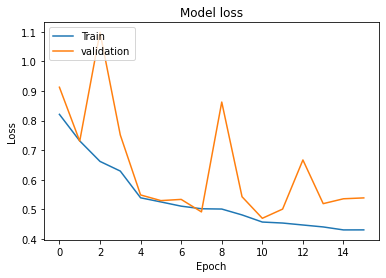

In [13]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()